In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.keras import layers, models

# Data Preprocessing

In [3]:
#loading the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('./data/card_transdata.csv')

## Data Visualization

### Describtive Analysis

In [4]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isna().any()

distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

### Histograms

<Figure size 2400x1600 with 0 Axes>

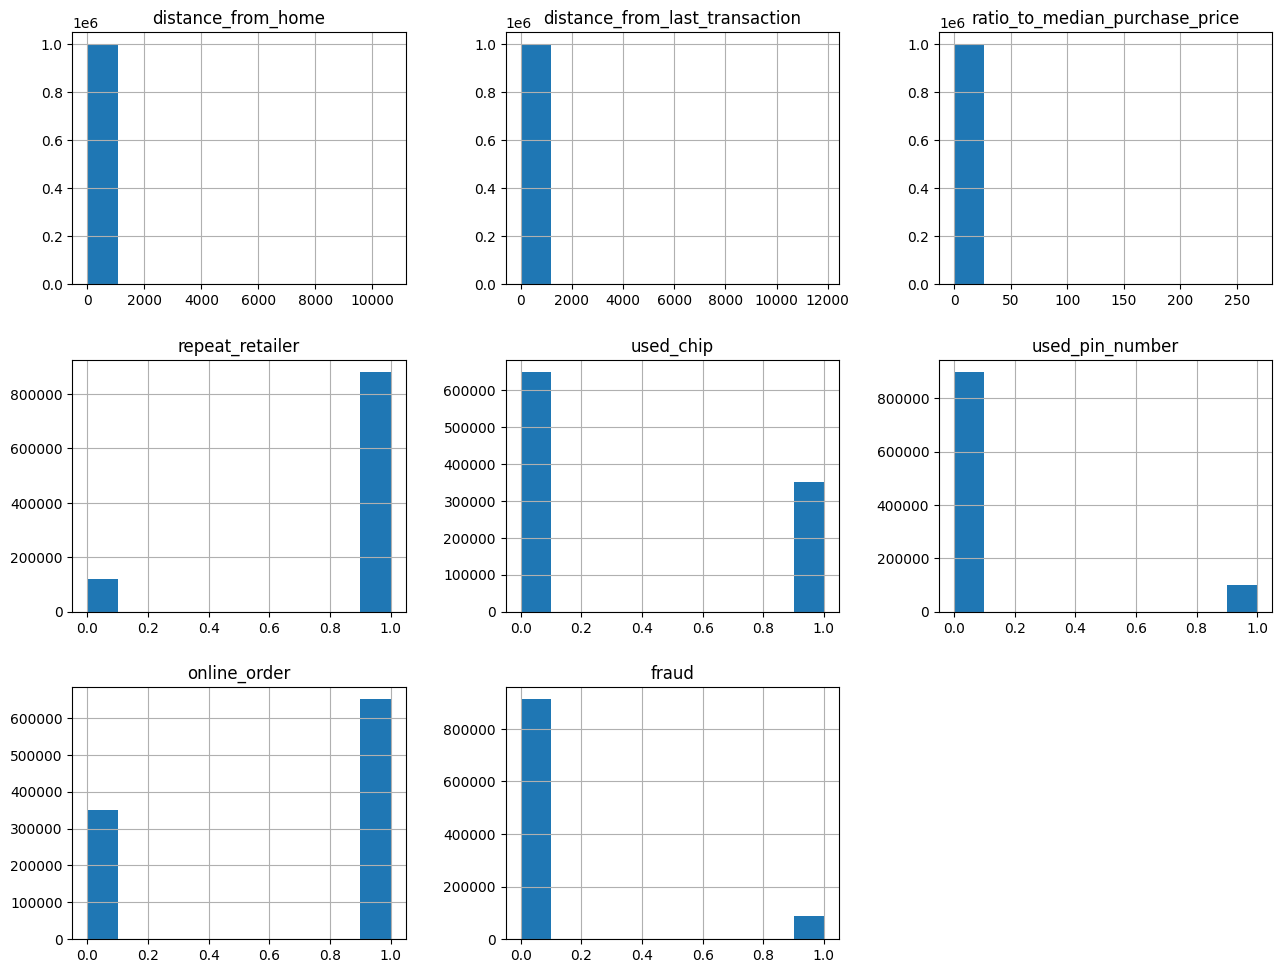

In [7]:
plt.figure(figsize=(24, 16)) 
df.hist()

plt.subplots_adjust(right=2, top=2)
plt.show()

# for col in df.columns:
#     plt.figure(figsize=(12, 8)) 
#     df.boxplot(column=col)
# plt.plot()

### Distributions

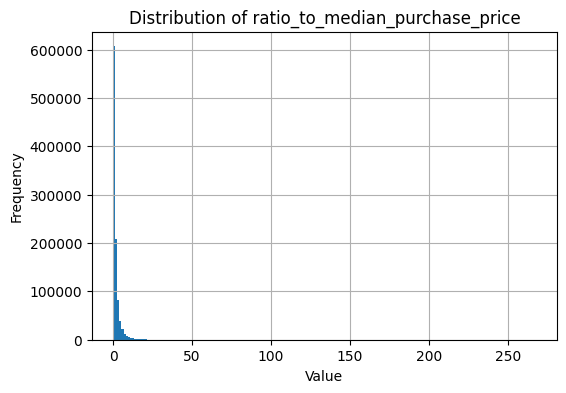

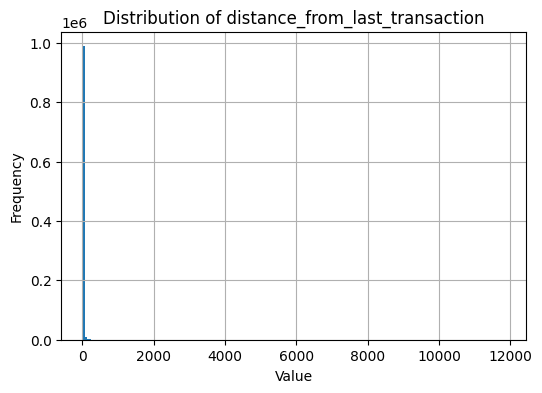

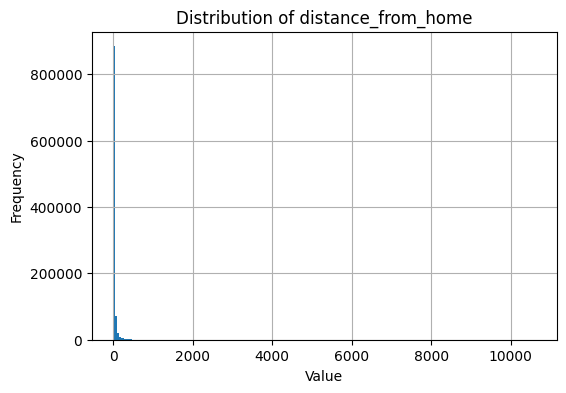

In [8]:
for col in ['ratio_to_median_purchase_price', 'distance_from_last_transaction', 'distance_from_home']:
    df[col].hist(bins=200, figsize=(6,4))
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

### Visualization analysis
In our dataset, we anticipate a predominant number of response variables to be zero. To address this imbalance, we will employ a stratified split approach for dividing the dataset into training and testing sets. This technique will ensure that the proportions of zero and non-zero values are consistently maintained across both sets, accurately reflecting the distribution in the original dataset. This approach is essential for preserving the integrity and representativeness of our data, thereby ensuring more reliable and valid model training and evaluation

## Data Preprocessing

Our analysis reveals that the columns __ratio_to_median_purchase_price__ and __distance_from_home__ exhibits a right-skewed distribution. This suggests that applying a log transformation could be beneficial to achieve a more normally distributed dataset. Furthermore, we observe that the columns __ratio_to_median_purchase_price__, __distance_from_last_transaction__, and __distance_from_home__ span a wide range of values, from 0 to 10,000. Neural networks are known not to perform will with values that have a large range. Therefore, we will employ a Standard Scaler as a preprocessing step to normalize these columns, ensuring that each feature contributes proportionately to the model's learning process.

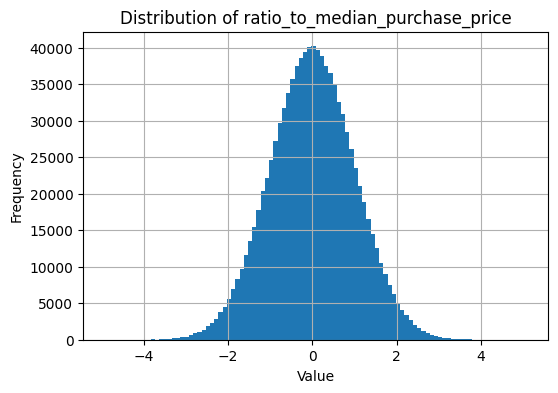

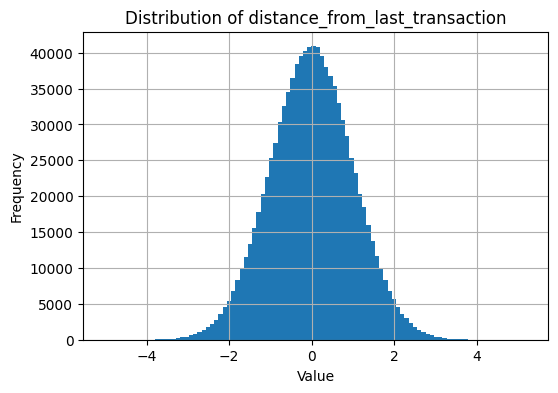

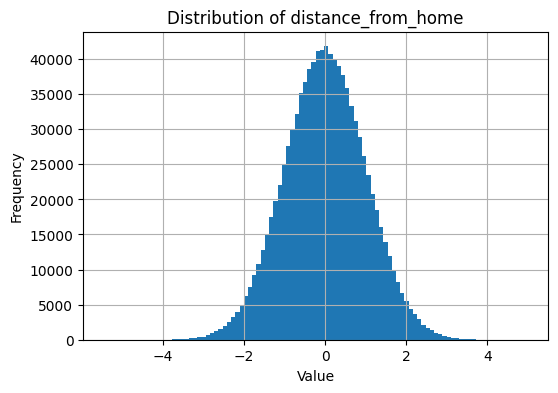

In [9]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
def data_preprocessing(X, show_hist=False):
    X = X.copy()
    cols = ['ratio_to_median_purchase_price', 'distance_from_last_transaction', 'distance_from_home']
    for i, col in enumerate(cols):
        # Adding an offset to the log tranformation to prevent taking the log of zero
        min_value = X[col].min()
        offset = 1 - min_value if min_value <= 0 else 0
        
        if col != 1:
            X[col] = np.log(X[col] + offset) 
        else:
            transformed_data, _ = boxcox(X[col] + offset) 
            X[col] = transformed_data
            
    for col in cols:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[[col]])

        if show_hist:
            X[col].hist(bins=100, figsize=(6, 4))
            plt.title(f'Distribution of {col}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.show()

    return X
df = data_preprocessing(df, True)


The provided code will divide the dataset into two distinct sets: a training set and a testing set. Specifically, 70% of the data will be allocated to the training set, while the remaining 30% will be designated for the testing set. This division ensures that a substantial portion of the dataset is used for model training, while still reserving a significant part for evaluating the model's performance.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.3, stratify=df['fraud'])
print('training set proportion: ', len(X_train) / (len(df)))
print('testing set proportion: ', len(X_test) / (len(df)))

training set proportion:  0.7
testing set proportion:  0.3


# Artificial Neural Network Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
def build_model(neurons, dropout_rate, activation, learning_rate):
    model = Sequential()
    
    model.add(Dense(units=neurons[0], input_shape=(7,), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=neurons[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=neurons[2], activation=activation))

    #output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model
    

In [12]:
params = {
    'neurons': [512, 256, 128],
    'dropout_rate': 0.5,
    'activation': 'relu',
    'learning_rate': 0.001
}
model = build_model(params['neurons'], params['dropout_rate'], params['activation'], params['learning_rate'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4096      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 168449 (658.00 KB)
Trainable params: 16844

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, verbose=2, callbacks=[early_stopping])
model.save('my_model.h5')

Epoch 1/10


17500/17500 - 47s - loss: 0.0389 - accuracy: 0.9846 - val_loss: 0.0174 - val_accuracy: 0.9934 - 47s/epoch - 3ms/step
Epoch 2/10
17500/17500 - 45s - loss: 0.0226 - accuracy: 0.9911 - val_loss: 0.0115 - val_accuracy: 0.9955 - 45s/epoch - 3ms/step
Epoch 3/10
17500/17500 - 45s - loss: 0.0195 - accuracy: 0.9924 - val_loss: 0.0109 - val_accuracy: 0.9959 - 45s/epoch - 3ms/step
Epoch 4/10
17500/17500 - 45s - loss: 0.0178 - accuracy: 0.9930 - val_loss: 0.0087 - val_accuracy: 0.9976 - 45s/epoch - 3ms/step
Epoch 5/10
17500/17500 - 45s - loss: 0.0168 - accuracy: 0.9936 - val_loss: 0.0107 - val_accuracy: 0.9959 - 45s/epoch - 3ms/step
Epoch 6/10
17500/17500 - 44s - loss: 0.0160 - accuracy: 0.9938 - val_loss: 0.0119 - val_accuracy: 0.9965 - 44s/epoch - 3ms/step
Epoch 7/10
17500/17500 - 43s - loss: 0.0158 - accuracy: 0.9939 - val_loss: 0.0084 - val_accuracy: 0.9973 - 43s/epoch - 2ms/step
Epoch 8/10
17500/17500 - 45s - loss: 0.0157 - accuracy: 0.9942 - val_loss: 0.0082 - val_accuracy: 0.99

In [15]:
from sklearn.metrics import confusion_matrix

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("Train accuracy:", train_acc)
print("Train Loss:", train_loss)
print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

# Generate predictions
predictions = model.predict(X_test)

predictions = (predictions > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, predictions)

print("Confusion Matrix:")
print(conf_matrix)

Train accuracy: 0.9972800016403198
Train Loss: 0.008171799592673779
Test accuracy: 0.9972266554832458
Test Loss: 0.008405677042901516
9375/9375 [==============================] - 12s 1ms/step
Confusion Matrix:
[[273421    358]
 [   474  25747]]


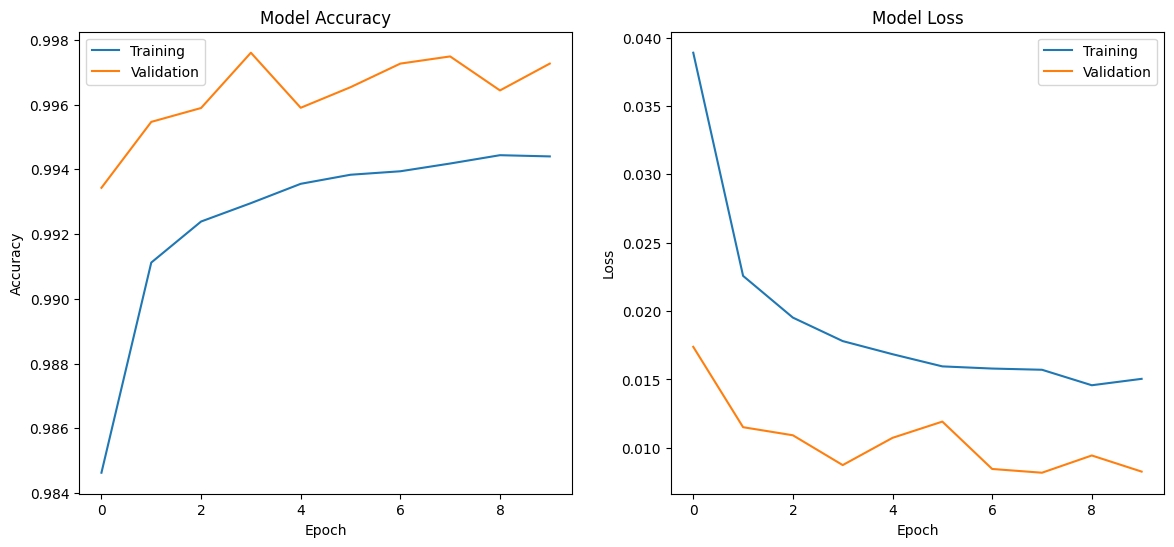

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()